# Competition - Restaurant Staffing Crisis

Management Science - La Étoile Three-Star Restaurant

## Client Briefing

**La Étoile**, our three-Michelin-star restaurant, faces a staffing
crisis this weekend.

### The Situation

“I need to schedule my 18 servers across 6 shifts this weekend. The
problem? My experienced servers cost €75/hour while juniors cost only
€25/hour. But it gets worse! Shifts have different lengths (4-6 hours),
servers have strong preferences about when they can work, and if I don’t
have enough experienced servers on busy shifts, we face penalties
ranging from €0 to €1,200 per missing experienced server from our parent
company!”

### The Challenge

You have **multiple competing objectives**. You need more experienced
servers than available, shifts have different lengths affecting labor
costs, and servers have varying preferences for different shifts.
**Critically, some servers cannot work certain shifts due to personal
commitments** (shown as preference = 0). Your job is to find the best
compromise:

-   Minimize total cost (labor + experience penalties + preference
    penalties)
-   **Respect hard availability constraints** (preference = 0 means
    CANNOT work that shift)
-   Balance multiple factors: shift coverage, server happiness, and
    costs
-   Strategic decisions: which expensive penalties to accept?
-   Navigate interdependencies created by availability constraints

> **Tip**
>
> Fortunately, La Étoile has already clearly quantified the weight of
> all objectives for you, so you don’t need to involve a pareto frontier
> in the optimization process.

### Your Resources

-   6 Experienced Servers (€75/hour)
-   12 Junior Servers (€25/hour)
-   6 Shifts to cover (3 servers each)
-   Everyone works exactly one shift

## The Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import Dict, List, Tuple

# Set seeds
np.random.seed(2025)
random.seed(2025)

# Server data
servers = pd.DataFrame({
    'Server_ID': [f'E{i:02d}' for i in range(1, 7)] + [f'J{i:02d}' for i in range(1, 13)],
    'Type': ['Experienced'] * 6 + ['Junior'] * 12,
    'Hourly_Rate': [75] * 6 + [25] * 12,
    'Name': ['François', 'Amélie', 'Baptiste', 'Céline', 'Damien', 'Élise'] +
            ['Jules', 'Margot', 'Théo', 'Camille', 'Léa', 'Hugo',
             'Emma', 'Louis', 'Chloé', 'Lucas', 'Manon', 'Ethan']
})

# Shift data with varying lengths - Weekend coverage
shifts = pd.DataFrame({
    'Shift_ID': ['FD', 'FL', 'SL', 'SD', 'UL', 'UD'],
    'Shift_Name': ['Friday Dinner', 'Friday Late', 'Saturday Lunch',
                   'Saturday Dinner', 'Sunday Lunch', 'Sunday Dinner'],
    'Day': ['Friday', 'Friday', 'Saturday', 'Saturday', 'Sunday', 'Sunday'],
    'Time': ['18:00-00:00', '23:00-03:00', '11:00-15:00',
             '17:00-21:00', '11:00-16:00', '17:00-22:00'],
    'Hours': [6, 4, 4, 4, 5, 5],  # Varying shift lengths create labor cost trade-offs!
    'Required_Servers': [3, 3, 3, 3, 3, 3],  # 18 total positions
    'Min_Experienced': [2, 0, 1, 2, 1, 2],  # 8 needed, 6 available = shortage of 2!
    'Expected_Covers': [120, 40, 80, 140, 90, 130],  # Number of guests
    'Penalty_Per_Missing': [800, 0, 500, 1500, 600, 1000]  # Large penalties!
})

# Server preferences (0 = CANNOT WORK, 1-10 = preference level)
np.random.seed(2025)
preferences = {}

# Hard availability constraints (0 = cannot work this shift)
# THE GREEDY TRAP: Overlapping availability creates assignment conflicts
# Greedy order: SD (€1500) → UD (€1000) → FD (€800) → UL (€600) → SL (€500) → FL (€0)
#
# The Trap: Make FD availability dependent on SD/UD choices
# - SD needs 2E: Can use François, Amélie, Élise
# - UD needs 2E: Can use François, Baptiste, Céline, Damien, Élise
# - FD needs 2E: Can use Amélie, Céline, Damien
#
# Greedy picks François+Élise for SD → Then Céline+Damien for UD → FD left with only Amélie!
# SA can rearrange assignments to avoid high FD penalty by accepting cheaper UL penalty
unavailable = {
    # Experienced server constraints - strategic overlaps
    'E01': ['FD', 'UL', 'SL', 'FL'],  # François: Can work SD, UD only
    'E02': ['UD', 'UL', 'SL', 'FL'],  # Amélie: Can work SD, FD, FL only
    'E03': ['SD', 'FD', 'SL', 'FL'],  # Baptiste: Can work UD, UL, FL only
    'E04': ['SD', 'SL', 'UL', 'FL'],  # Céline: Can work FD, UD only
    'E05': ['SD', 'SL', 'UL', 'FL'],  # Damien: Can work FD, UD only
    'E06': ['FD', 'UL', 'SL', 'FL'],  # Élise: Can work SD, UD, FL only
    # Junior constraints
    'J02': ['SD', 'UD', 'FD'],
    'J05': ['SD', 'UD', 'FD'],
    'J08': ['SD', 'UD', 'FD'],
}

for _, server in servers.iterrows():
    server_prefs = []
    for _, shift in shifts.iterrows():
        # Check hard constraints first
        if server['Server_ID'] in unavailable and shift['Shift_ID'] in unavailable[server['Server_ID']]:
            pref = 0  # CANNOT WORK
        else:
            # Generate preferences based on server type
            if server['Type'] == 'Experienced':
                if 'Dinner' in shift['Shift_Name']:
                    pref = np.random.choice([5, 7, 8, 9, 10], p=[0.1, 0.2, 0.3, 0.3, 0.1])
                elif 'Late' in shift['Shift_Name']:
                    pref = np.random.choice([1, 2, 3, 4, 5], p=[0.2, 0.3, 0.2, 0.2, 0.1])
                else:  # Lunch
                    pref = np.random.choice([3, 4, 5, 6, 7], p=[0.1, 0.2, 0.3, 0.3, 0.1])
            else:  # Junior servers
                if 'Late' in shift['Shift_Name']:
                    pref = np.random.choice([4, 6, 7, 8, 9], p=[0.1, 0.2, 0.2, 0.3, 0.2])
                elif 'Lunch' in shift['Shift_Name']:
                    pref = np.random.choice([3, 5, 6, 7, 8], p=[0.1, 0.2, 0.3, 0.3, 0.1])
                else:  # Dinner
                    pref = np.random.choice([2, 4, 5, 6, 7], p=[0.1, 0.2, 0.3, 0.3, 0.1])
        server_prefs.append(pref)
    preferences[server['Server_ID']] = server_prefs

# Create preference matrix
pref_matrix = pd.DataFrame(preferences, index=shifts['Shift_ID']).T
print("\n\nSERVER PREFERENCES (0=CANNOT WORK, 1=hates it, 10=loves it):")
print("=" * 60)
print(pref_matrix.to_string())
print("\nAvailability Constraints:")
for server_id, shifts_unavailable in unavailable.items():
    server_name = servers[servers['Server_ID'] == server_id].iloc[0]['Name']
    print(f"  {server_name} ({server_id}): Cannot work {', '.join(shifts_unavailable)}")

print("SERVERS AVAILABLE:")
print("=" * 60)
print(servers.to_string(index=False))

print("\n\nSHIFT REQUIREMENTS:")
print("=" * 60)
print(shifts.to_string(index=False))

print("\n\nTHE PROBLEM:")
print("=" * 60)
print(f"Total experienced servers needed: {shifts['Min_Experienced'].sum()}")
print(f"Total experienced servers available: {(servers['Type'] == 'Experienced').sum()}")
print(f"SHORTAGE: {shifts['Min_Experienced'].sum() - (servers['Type'] == 'Experienced').sum()} experienced servers!")
print("\nComplex factors:")
print(" • HARD CONSTRAINTS: Some servers cannot work certain shifts (pref=0)")
print(" • Varying shift lengths (4-6 hours) affect total labor cost")
print(" • Large penalty amounts (€500-€1200) make choices strategic")
print(" • Server preferences (1-10) affect morale and quality")
print(" • Lower preferences = unhappy staff = significant quality penalty")
print(f" • Availability constraints create interdependencies between assignments")



SERVER PREFERENCES (0=CANNOT WORK, 1=hates it, 10=loves it):
Shift_ID  FD  FL  SL  SD  UL  UD
E01        0   0   0   7   0   9
E02       10   0   0   8   0   0
E03        0   0   0   0   5   7
E04        9   0   0   0   0   8
E05       10   0   0   0   0   9
E06        0   0   0   8   0   9
J01        2   8   3   4   7   7
J02        0   7   5   0   7   0
J03        7   7   5   7   8   4
J04        5   6   3   5   8   5
J05        0   9   3   0   5   0
J06        5   8   8   5   8   5
J07        6   9   6   6   5   5
J08        0   6   6   0   7   0
J09        6   6   6   2   8   7
J10        4   9   6   4   7   5
J11        7   8   8   7   5   5
J12        6   8   6   6   7   6

Availability Constraints:
  François (E01): Cannot work FD, UL, SL, FL
  Amélie (E02): Cannot work UD, UL, SL, FL
  Baptiste (E03): Cannot work SD, FD, SL, FL
  Céline (E04): Cannot work SD, SL, UL, FL
  Damien (E05): Cannot work SD, SL, UL, FL
  Élise (E06): Cannot work FD, UL, SL, FL
  Margot (J02): Cannot

## Understanding the Costs

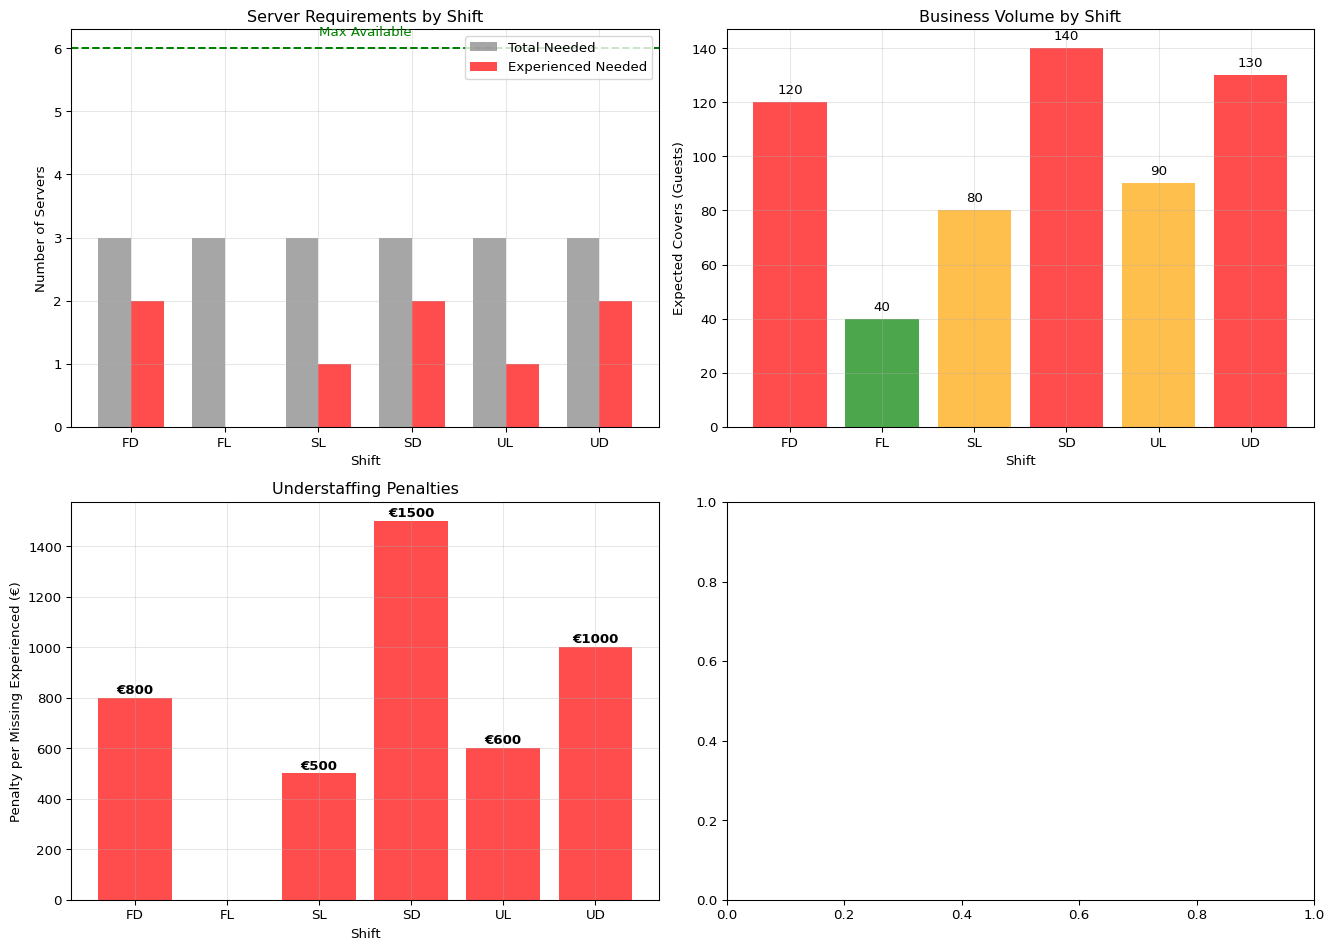

In [2]:
# Visualize the requirements and cost impacts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top Left: Shift requirements
ax = axes[0, 0]
x = range(len(shifts))
width = 0.35
ax.bar([i - width/2 for i in x], shifts['Required_Servers'], width, 
       label='Total Needed', color='gray', alpha=0.7)
ax.bar([i + width/2 for i in x], shifts['Min_Experienced'], width,
       label='Experienced Needed', color='red', alpha=0.7)
ax.set_xlabel('Shift')
ax.set_ylabel('Number of Servers')
ax.set_title('Server Requirements by Shift')
ax.set_xticks(x)
ax.set_xticklabels(shifts['Shift_ID'])
ax.legend()
ax.axhline(y=6, color='green', linestyle='--', label='Available Experienced')
ax.text(2.5, 6.2, 'Max Available', fontsize=10, color='green', ha='center')
ax.grid(True, alpha=0.3)

# Expected covers (business volume)
ax = axes[0, 1]
colors = ['red' if covers > 100 else 'orange' if covers > 60 else 'green'
          for covers in shifts['Expected_Covers']]
bars = ax.bar(shifts['Shift_ID'], shifts['Expected_Covers'], color=colors, alpha=0.7)
ax.set_xlabel('Shift')
ax.set_ylabel('Expected Covers (Guests)')
ax.set_title('Business Volume by Shift')
ax.grid(True, alpha=0.3)

# Add value labels
for bar, val in zip(bars, shifts['Expected_Covers']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
           str(val), ha='center', va='bottom')

# Penalty structure
ax = axes[1, 0]
penalties = shifts['Penalty_Per_Missing'].values
bars = ax.bar(shifts['Shift_ID'], penalties, color=['red' if p > 0 else 'green' for p in penalties], alpha=0.7)
ax.set_xlabel('Shift')
ax.set_ylabel('Penalty per Missing Experienced (€)')
ax.set_title('Understaffing Penalties')
ax.grid(True, alpha=0.3)

# Add annotations
for bar, val in zip(bars, penalties):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
               f'€{val}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Helper Functions

In [3]:
def calculate_schedule_cost(schedule: Dict[str, List[str]], 
                           servers_df: pd.DataFrame, 
                           shifts_df: pd.DataFrame) -> Tuple[float, Dict]:
    """
    Calculate total cost of a schedule including labor, penalties, and preference scores.
    
    Returns:
        total_cost: Total cost in euros
        cost_breakdown: Dictionary with detailed cost breakdown
    """
    labor_cost = 0
    penalty_cost = 0
    preference_penalty = 0  # penalty for poor preference matches
    availability_violation_penalty = 0  # HUGE penalty for assigning unavailable servers
    violations = []
    preference_score = 0
    availability_violations = 0

    for shift_idx, shift_row in shifts_df.iterrows():
        shift_id = shift_row['Shift_ID']

        if shift_id not in schedule:
            continue

        assigned_servers = schedule[shift_id]

        # Calculate labor cost for this shift (now with varying hours!)
        for server_id in assigned_servers:
            server = servers_df[servers_df['Server_ID'] == server_id].iloc[0]
            labor_cost += server['Hourly_Rate'] * shift_row['Hours']

            # Check availability constraints
            server_pref = pref_matrix.loc[server_id, shift_id]

            if server_pref == 0:
                # CRITICAL: Cannot assign unavailable servers!
                # Massive penalty to make this infeasible
                availability_violation_penalty += 10000
                availability_violations += 1
            else:
                # Penalty for low preferences (encourage happy staff)
                # Scale: 1 (worst) = €180 penalty, 10 (best) = €0 penalty
                preference_penalty += (10 - server_pref) * 20
                preference_score += server_pref
        
        # Check experienced server requirement
        experienced_count = sum(1 for sid in assigned_servers 
                               if servers_df[servers_df['Server_ID'] == sid].iloc[0]['Type'] == 'Experienced')
        
        shortage = max(0, shift_row['Min_Experienced'] - experienced_count)
        if shortage > 0:
            penalty = shortage * shift_row['Penalty_Per_Missing']
            penalty_cost += penalty
            violations.append({
                'shift': shift_row['Shift_Name'],
                'needed': shift_row['Min_Experienced'],
                'assigned': experienced_count,
                'shortage': shortage,
                'penalty': penalty
            })
    
    total_cost = labor_cost + penalty_cost + preference_penalty + availability_violation_penalty

    cost_breakdown = {
        'labor_cost': labor_cost,
        'penalty_cost': penalty_cost,
        'preference_penalty': preference_penalty,
        'availability_violation_penalty': availability_violation_penalty,
        'availability_violations': availability_violations,
        'total_cost': total_cost,
        'violations': violations,
        'average_preference': preference_score / (18 - availability_violations) if (18 - availability_violations) > 0 else 0
    }

    return total_cost, cost_breakdown

def validate_schedule(schedule: Dict[str, List[str]], 
                     servers_df: pd.DataFrame, 
                     shifts_df: pd.DataFrame) -> Tuple[bool, List[str]]:
    """
    Validate that a schedule meets all hard constraints.
    
    Returns:
        is_valid: Boolean indicating if schedule is valid
        errors: List of constraint violations
    """
    errors = []
    
    # Check each shift has exactly 3 servers
    for shift_row in shifts_df.itertuples():
        if shift_row.Shift_ID not in schedule:
            errors.append(f"Shift {shift_row.Shift_Name} has no assignment")
        elif len(schedule[shift_row.Shift_ID]) != shift_row.Required_Servers:
            errors.append(f"Shift {shift_row.Shift_Name} has {len(schedule[shift_row.Shift_ID])} servers, needs {shift_row.Required_Servers}")
    
    # Check each server works exactly once
    all_assignments = []
    for shift_servers in schedule.values():
        all_assignments.extend(shift_servers)
    
    server_counts = pd.Series(all_assignments).value_counts()
    
    # Check no duplicates
    for server_id, count in server_counts.items():
        if count > 1:
            errors.append(f"Server {server_id} assigned {count} times (should be 1)")
    
    # Check all servers are assigned
    all_server_ids = set(servers_df['Server_ID'])
    assigned_ids = set(all_assignments)
    
    if len(assigned_ids) != len(all_server_ids):
        missing = all_server_ids - assigned_ids
        if missing:
            errors.append(f"Servers not assigned: {', '.join(missing)}")

    # Check availability constraints (preference = 0 means cannot work)
    for shift_id, assigned_servers in schedule.items():
        for server_id in assigned_servers:
            pref = pref_matrix.loc[server_id, shift_id]
            if pref == 0:
                shift_name = shifts_df[shifts_df['Shift_ID'] == shift_id].iloc[0]['Shift_Name']
                errors.append(f"AVAILABILITY VIOLATION: {server_id} assigned to {shift_name} but is unavailable (preference=0)")

    is_valid = len(errors) == 0
    return is_valid, errors

def visualize_schedule(schedule: Dict[str, List[str]], 
                      servers_df: pd.DataFrame,
                      shifts_df: pd.DataFrame,
                      cost_breakdown: Dict):
    """Create a visual representation of the schedule."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Schedule Grid
    ax = axes[0, 0]
    
    # Create schedule matrix
    schedule_matrix = np.zeros((len(servers_df), len(shifts_df)))
    
    for shift_idx, shift_row in shifts_df.iterrows():
        shift_id = shift_row['Shift_ID']
        if shift_id in schedule:
            for server_id in schedule[shift_id]:
                server_idx = servers_df[servers_df['Server_ID'] == server_id].index[0]
                schedule_matrix[server_idx, shift_idx] = 1
    
    # Color based on server type
    colors = []
    for server in servers_df.itertuples():
        if server.Type == 'Experienced':
            colors.append('red')
        else:
            colors.append('blue')
    
    # Plot
    im = ax.imshow(schedule_matrix, cmap='YlOrRd', aspect='auto')
    ax.set_xticks(range(len(shifts_df)))
    ax.set_xticklabels(shifts_df['Shift_ID'])
    ax.set_yticks(range(len(servers_df)))
    ax.set_yticklabels([f"{row.Server_ID} ({row.Type[0]})" for row in servers_df.itertuples()], 
                       fontsize=8)
    ax.set_xlabel('Shift')
    ax.set_ylabel('Server')
    ax.set_title('Schedule Assignment Matrix')
    
    # Add grid
    for i in range(len(servers_df) + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5)
    for i in range(len(shifts_df) + 1):
        ax.axvline(i - 0.5, color='gray', linewidth=0.5)
    
    # 2. Cost Breakdown
    ax = axes[0, 1]
    costs = {
        'Labor': cost_breakdown['labor_cost'],
        'Penalties': cost_breakdown['penalty_cost']
    }
    bars = ax.bar(costs.keys(), costs.values(), color=['green', 'red'], alpha=0.7)
    ax.set_ylabel('Cost (€)')
    ax.set_title(f"Total Cost: €{cost_breakdown['total_cost']:.2f}")
    
    for bar, val in zip(bars, costs.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
               f'€{val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Violations
    ax = axes[1, 0]
    if cost_breakdown['violations']:
        violations_df = pd.DataFrame(cost_breakdown['violations'])
        x = range(len(violations_df))
        ax.bar(x, violations_df['shortage'], color='red', alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(violations_df['shift'], rotation=45, ha='right')
        ax.set_ylabel('Missing Experienced Servers')
        ax.set_title('Understaffing by Shift')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No Violations!\n(All requirements met)', 
               ha='center', va='center', fontsize=14, color='green')
        ax.set_title('Violations')
    ax.axis('on')
    
    # 4. Server Type Distribution
    ax = axes[1, 1]
    shift_composition = []
    for shift_id in shifts_df['Shift_ID']:
        if shift_id in schedule:
            exp_count = sum(1 for sid in schedule[shift_id]
                          if servers_df[servers_df['Server_ID'] == sid].iloc[0]['Type'] == 'Experienced')
            jun_count = len(schedule[shift_id]) - exp_count
            shift_composition.append({'Shift': shift_id, 'Experienced': exp_count, 'Junior': jun_count})
    
    if shift_composition:
        comp_df = pd.DataFrame(shift_composition)
        x = range(len(comp_df))
        width = 0.35
        ax.bar([i - width/2 for i in x], comp_df['Experienced'], width, 
               label='Experienced', color='red', alpha=0.7)
        ax.bar([i + width/2 for i in x], comp_df['Junior'], width,
               label='Junior', color='blue', alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(comp_df['Shift'])
        ax.set_ylabel('Number of Servers')
        ax.set_title('Staff Composition by Shift')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example: Test with a random valid schedule
def create_random_schedule(servers_df, shifts_df):
    """Create a random valid schedule for testing."""
    schedule = {}
    available_servers = list(servers_df['Server_ID'])
    random.shuffle(available_servers)
    
    server_idx = 0
    for shift_row in shifts_df.itertuples():
        schedule[shift_row.Shift_ID] = available_servers[server_idx:server_idx + shift_row.Required_Servers]
        server_idx += shift_row.Required_Servers
    
    return schedule

# Test the helper functions
test_schedule = create_random_schedule(servers, shifts)
test_cost, test_breakdown = calculate_schedule_cost(test_schedule, servers, shifts)
is_valid, errors = validate_schedule(test_schedule, servers, shifts)

print(f"\nRANDOM SCHEDULE TEST:")
print(f"Valid: {is_valid}")
print(f"Total Cost: €{test_cost:.2f}")
print(f"  - Labor: €{test_breakdown['labor_cost']:.2f}")
print(f"  - Penalties: €{test_breakdown['penalty_cost']:.2f}")
if test_breakdown['violations']:
    print(f"Violations: {len(test_breakdown['violations'])} shifts understaffed")


RANDOM SCHEDULE TEST:
Valid: False
Total Cost: €58440.00
  - Labor: €3400.00
  - Penalties: €4100.00
Violations: 3 shifts understaffed

## Your Task

Design the optimal server schedule that minimizes total cost while
managing multiple complex constraints.

### The Challenge

This is NOT a simple assignment problem! You must balance:

-   **Varying shift lengths** (4-6 hours) that affect labor costs
    differently
-   **Server preferences** (1-10) where lower values mean unhappy staff
    and quality issues
-   **Strategic penalty decisions** - penalties range from €0 to €1200
-   **Three cost components**: labor + experience penalties + preference
    penalties

### Approach Options

You can use ANY approach you prefer:

1.  **Smart Greedy** - Consider preferences AND penalties in your rules
2.  **Local Search** - Start with valid schedule (respecting 0
    preferences), improve with constraint-aware swaps
3.  **Metaheuristics** - Use AI to implement SA, GA, etc. that handle
    hard constraints
4.  **Hybrid** - Combine approaches (e.g., greedy for feasibility, then
    SA for optimization)
5.  **Creative** - Surprise us with novel constraint-handling
    techniques!

**Remember**: Unhappy staff (low preferences) lead to quality issues and
small penalties that add up!

## Your Solution

Implement your solution below. You can use greedy, metaheuristic, or
hybrid approaches.

### AI-Assisted Metaheuristic Template

In [4]:
# Template for using AI to implement metaheuristics

ai_prompt_template = """
I need to solve a complex restaurant staff scheduling problem using [ALGORITHM NAME].

PROBLEM DETAILS:
- 18 servers total: 6 experienced (€75/hour), 12 junior (€25/hour)
- 6 shifts with VARYING lengths (4-6 hours each), each needs exactly 3 servers
- Each server works exactly ONE shift
- Some shifts need minimum experienced servers, but we don't have enough

CONSTRAINTS:
- Each shift: exactly 3 servers
- Each server: exactly 1 shift
- Experienced servers needed: [2, 0, 1, 2, 1, 2] for shifts
- Available experienced: only 6 (need 8 total)
- Server preferences: 1-10 scale (1 = hates it, 10 = loves it)
- Shift hours: [5, 4, 4, 6, 5, 6] for shifts FD, FL, SL, SD, UL, UD

OBJECTIVE:
Minimize: labor_cost + experience_penalty + preference_penalty
- Labor: hourly_rate × shift_hours (varies by shift!)
- Experience penalty: [€800, €0, €500, €1200, €600, €1000] per missing experienced
- Preference penalty: (10 - preference) × €20 for each assignment
                     (so preference=1 costs €180, preference=10 costs €0)

AVAILABLE DATA:
- pref_matrix: DataFrame with preferences (rows=servers, cols=shifts)
- shifts: DataFrame with shift details (hours, penalties, requirements)
- servers: DataFrame with server types and hourly rates

Please provide:
1. Solution representation (how to encode a schedule)
2. Neighborhood/move function that considers preferences
3. Cost calculation including all three components
4. Main algorithm loop with preference-aware optimization
5. Parameter recommendations for this specific problem

The schedule should be a dictionary: {shift_id: [list of 3 server_ids]}
Better preferences = lower costs and happier staff!
"""

print("AI IMPLEMENTATION TEMPLATE")
print("=" * 60)
print(ai_prompt_template)
print("=" * 60)
print("\nReplace [ALGORITHM NAME] with:")
print("- 'simulated annealing' for SA")
print("- 'genetic algorithm' for GA")
print("- 'tabu search' for Tabu")
print("\nPaste this into ChatGPT or GitHub Copilot!")

AI IMPLEMENTATION TEMPLATE

I need to solve a complex restaurant staff scheduling problem using [ALGORITHM NAME].

PROBLEM DETAILS:
- 18 servers total: 6 experienced (€75/hour), 12 junior (€25/hour)
- 6 shifts with VARYING lengths (4-6 hours each), each needs exactly 3 servers
- Each server works exactly ONE shift
- Some shifts need minimum experienced servers, but we don't have enough

CONSTRAINTS:
- Each shift: exactly 3 servers
- Each server: exactly 1 shift
- Experienced servers needed: [2, 0, 1, 2, 1, 2] for shifts
- Available experienced: only 6 (need 8 total)
- Server preferences: 1-10 scale (1 = hates it, 10 = loves it)
- Shift hours: [5, 4, 4, 6, 5, 6] for shifts FD, FL, SL, SD, UL, UD

OBJECTIVE:
Minimize: labor_cost + experience_penalty + preference_penalty
- Labor: hourly_rate × shift_hours (varies by shift!)
- Experience penalty: [€800, €0, €500, €1200, €600, €1000] per missing experienced
- Preference penalty: (10 - preference) × €20 for each assignment
                  

## Your Solution

Implement your solution below:

In [5]:
# YOUR SOLUTION CODE HERE

def my_scheduling_algorithm(servers_df, shifts_df):
    """
    Your scheduling algorithm implementation.
    Can be greedy, metaheuristic, or hybrid.
    """
    # YOUR CODE HERE

    # Example structure (replace with your approach):
    schedule = {}

    # ... your implementation ...

    # For now, returning a random solution as placeholder
    return create_random_schedule(servers_df, shifts_df)

# Run your solution
my_schedule = my_scheduling_algorithm(servers, shifts)
my_cost, my_breakdown = calculate_schedule_cost(my_schedule, servers, shifts)

# Validate
is_valid, validation_errors = validate_schedule(my_schedule, servers, shifts)

print("MY SOLUTION:")
print("=" * 60)
if not is_valid:
    print("⚠️ INVALID SCHEDULE:")
    for error in validation_errors:
        print(f"  - {error}")
else:
    print("✓ Valid Schedule")
    
print(f"\nTotal Cost: €{my_cost:.2f}")
print(f"  Labor: €{my_breakdown['labor_cost']:.2f}")
print(f"  Penalties: €{my_breakdown['penalty_cost']:.2f}")

print(f"\nImprovement over random: {(test_cost - my_cost)/test_cost*100:.1f}%")

# Visualize your solution
if is_valid:
    visualize_schedule(my_schedule, servers, shifts, my_breakdown)

MY SOLUTION:
⚠️ INVALID SCHEDULE:
  - AVAILABILITY VIOLATION: E03 assigned to Friday Dinner but is unavailable (preference=0)
  - AVAILABILITY VIOLATION: E06 assigned to Friday Late but is unavailable (preference=0)
  - AVAILABILITY VIOLATION: E01 assigned to Sunday Lunch but is unavailable (preference=0)
  - AVAILABILITY VIOLATION: J08 assigned to Sunday Dinner but is unavailable (preference=0)

Total Cost: €47520.00
  Labor: €3600.00
  Penalties: €3000.00

Improvement over random: 18.7%

## Competition Submission

Create your final submission:

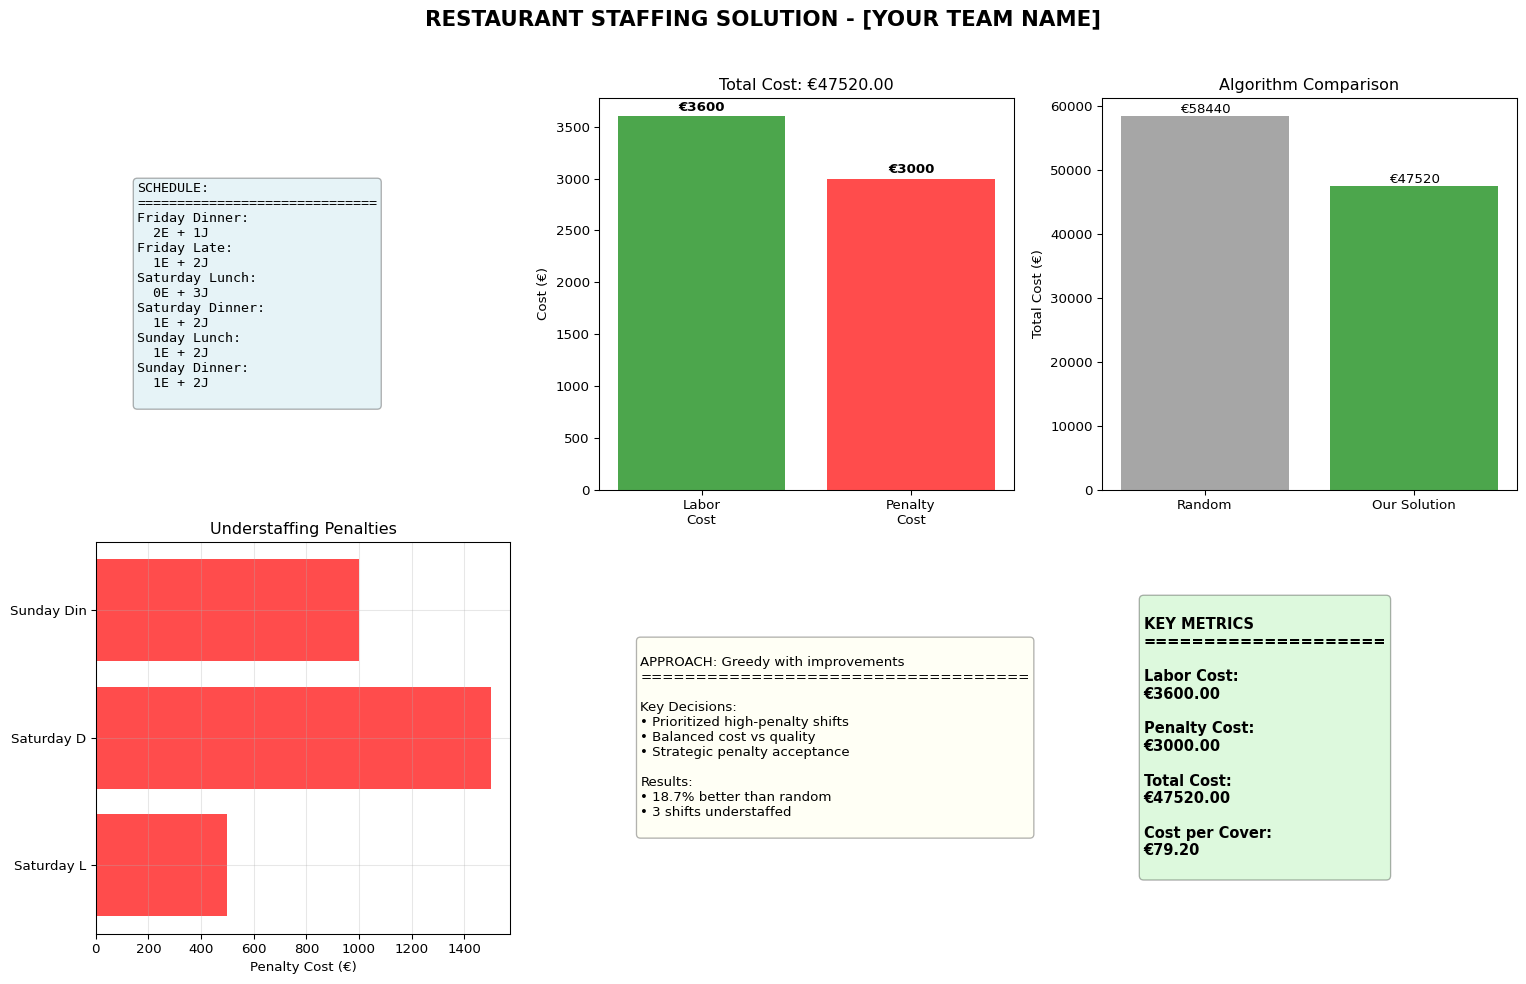


SUBMISSION READY!
Total Cost: €47520.00
Approach: Greedy with improvements

Good luck in the competition!

In [6]:
# Generate submission summary
submission = {
    'team_name': 'YOUR_TEAM_NAME',  # CHANGE THIS
    'approach': 'Greedy with improvements',  # DESCRIBE YOUR APPROACH
    'total_cost': my_cost,
    'labor_cost': my_breakdown['labor_cost'],
    'penalty_cost': my_breakdown['penalty_cost'],
    'violations': len(my_breakdown['violations']),
    'schedule': my_schedule
}

# Create executive summary slide
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('RESTAURANT STAFFING SOLUTION - [YOUR TEAM NAME]', 
             fontsize=16, fontweight='bold', y=1.02)

# 1. Schedule Overview
ax = axes[0, 0]
ax.axis('off')
schedule_text = "SCHEDULE:\n" + "="*30 + "\n"
for shift_id in shifts['Shift_ID']:
    shift_name = shifts[shifts['Shift_ID'] == shift_id].iloc[0]['Shift_Name']
    if shift_id in my_schedule:
        exp_count = sum(1 for sid in my_schedule[shift_id]
                       if servers[servers['Server_ID'] == sid].iloc[0]['Type'] == 'Experienced')
        schedule_text += f"{shift_name}:\n  {exp_count}E + {3-exp_count}J\n"

ax.text(0.1, 0.5, schedule_text, fontsize=10, family='monospace',
       verticalalignment='center',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 2. Cost Breakdown
ax = axes[0, 1]
costs = [my_breakdown['labor_cost'], my_breakdown['penalty_cost']]
labels = ['Labor\nCost', 'Penalty\nCost']
colors = ['green', 'red'] if my_breakdown['penalty_cost'] > 0 else ['green', 'green']
bars = ax.bar(labels, costs, color=colors, alpha=0.7)
ax.set_ylabel('Cost (€)')
ax.set_title(f'Total Cost: €{my_cost:.2f}')

for bar, val in zip(bars, costs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
           f'€{val:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Comparison
ax = axes[0, 2]
comparison = {
    'Random': test_cost,
    'Our Solution': my_cost
}
x = range(len(comparison))
colors = ['gray', 'green']
bars = ax.bar(x, comparison.values(), color=colors, alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(comparison.keys())
ax.set_ylabel('Total Cost (€)')
ax.set_title('Algorithm Comparison')

for bar, val in zip(bars, comparison.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
           f'€{val:.0f}', ha='center', va='bottom')

# 4. Violations Detail
ax = axes[1, 0]
if my_breakdown['violations']:
    violation_shifts = [v['shift'][:10] for v in my_breakdown['violations']]
    violation_costs = [v['penalty'] for v in my_breakdown['violations']]
    ax.barh(violation_shifts, violation_costs, color='red', alpha=0.7)
    ax.set_xlabel('Penalty Cost (€)')
    ax.set_title('Understaffing Penalties')
else:
    ax.text(0.5, 0.5, 'No Violations!', ha='center', va='center',
           fontsize=14, color='green', fontweight='bold')
    ax.set_title('Perfect Staffing!')
ax.grid(True, alpha=0.3)

# 5. Approach Description
ax = axes[1, 1]
ax.axis('off')
approach_text = f"""
APPROACH: {submission['approach']}
{'='*35}

Key Decisions:
• Prioritized high-penalty shifts
• Balanced cost vs quality
• Strategic penalty acceptance

Results:
• {(test_cost - my_cost)/test_cost*100:.1f}% better than random
• {submission['violations']} shifts understaffed
"""
ax.text(0.1, 0.5, approach_text, fontsize=10,
       verticalalignment='center',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

# 6. Key Metrics
ax = axes[1, 2]
ax.axis('off')
metrics_text = f"""
KEY METRICS
{'='*20}

Labor Cost:
€{my_breakdown['labor_cost']:.2f}

Penalty Cost:
€{my_breakdown['penalty_cost']:.2f}

Total Cost:
€{my_cost:.2f}

Cost per Cover:
€{my_cost / shifts['Expected_Covers'].sum():.2f}
"""
ax.text(0.1, 0.5, metrics_text, fontsize=11, fontweight='bold',
       verticalalignment='center',
       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUBMISSION READY!")
print("="*60)
print(f"Total Cost: €{submission['total_cost']:.2f}")
print(f"Approach: {submission['approach']}")
print("\nGood luck in the competition!")

## Evaluation Rubric

| Criterion | Points | What We Look For |
|---------------------|----------------|------------------------------------|
| **Solution Quality** | 40 | Lower total cost (labor + experience + preferences) |
| **Constraint Handling** | 25 | Smart penalty choices, balances all three cost components |
| **Approach** | 20 | Handles complexity well, good algorithm choice |
| **Code Quality** | 10 | Clean, documented, correct |
| **Presentation** | 5 | Clear explanation of trade-offs |
| **Total** | 100 |  |

### Tips for Success

1.  **Understand the Complex Trade-offs**
    -   Longer shifts (6 hours) cost more in labor but might be worth it
        for experienced servers
    -   Preference penalties can add up quickly - prioritize happy staff
    -   Some penalty differences are huge (€0 vs €1200)
2.  **Think Strategically**
    -   Friday Late: 0 penalty AND only 4 hours - perfect for juniors
        who like late shifts!
    -   Saturday Dinner: 6 hours + €1200 penalty - needs your best
        experienced servers
    -   Use preference matrix strategically - happy staff = better
        quality = lower costs
3.  **Algorithm Considerations**
    -   Simple greedy works but may not optimize preferences well
    -   Metaheuristics can better balance all three cost components
    -   Consider preference-aware neighborhoods in your local search
4.  **Try Multiple Approaches**
    -   Start with greedy
    -   Improve with local search
    -   Consider metaheuristics if time allows
5.  **Use AI Wisely**
    -   Let AI help with implementation
    -   But understand what it’s doing
    -   Verify the results make sense
6.  **Document Your Logic**
    -   Explain WHY you made certain choices
    -   Show you understand the business impact

<span class="highlight">Good luck! May the best schedule win!</span>